
# Import and model

In [102]:
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import torch
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [103]:
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

c:\Users\DELL\miniconda3\envs\CS336\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [104]:
def normalize_data(data):
    # Kiểm tra nếu data là một vector 1 chiều
    if data.ndim == 1:
        normalized_data = data / np.linalg.norm(data)
    else:
        # Chuẩn hóa dữ liệu nếu là mảng 2 chiều
        normalized_data = data / np.linalg.norm(data, axis=1, keepdims=True)
    
    return normalized_data

In [105]:
def extract_clip_feature(images, device='cpu'):
#   images = [Image.open(path).convert('RGB') for path in image_paths]
  features = []
  for image in images:
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model.get_image_features(image)
    feature = feature.squeeze().cpu().numpy()
    features.append(feature)

  return features

# Parameters

In [106]:
gt_path = r'C:\Retrieval System\data\paris_120310_gt'
data_path = r'C:\Retrieval System\data\paris'
features_path = r'C:\Retrieval System\features\features_paris_clip'

In [107]:
k = 6392

# Get input features

In [108]:
def process_queries(query_file, device='cpu'):
    """
    Đọc file query, cắt ảnh theo bounding box và extract feature theo từng bb.
    
    :param query_file: Đường dẫn đến file query.txt
    :param image_folder: Thư mục chứa ảnh
    """
    with open(query_file, 'r') as file:
        features = []
        for line in file:
            # Tách dòng query thành các phần tử
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            
            image_name = parts[0] + '.jpg'  # Tên file ảnh
            x1, y1, x2, y2 = map(float, parts[1:])  # Bounding box
            
            # Đường dẫn đầy đủ đến ảnh
            image_path = os.path.join(data_path, image_name.split('_')[1], image_name)
            
            # Kiểm tra ảnh tồn tại
            if not os.path.exists(image_path):
                print(f"Ảnh {image_name} không tồn tại trong thư mục {os.path.join(data_path, image_name.split('_')[1])}.")
                continue
            
            # Mở ảnh và cắt theo bounding box
            with Image.open(image_path).convert('RGB') as img:
                cropped_img = img.crop((x1, y1, x2, y2))  # Cắt ảnh
                # Extract feature của ảnh crop
                cropped_img = transform(cropped_img).unsqueeze(0).to(device)
                with torch.no_grad():
                    feature = model.get_image_features(cropped_img)
                feature = feature.squeeze().cpu().numpy()
                features.append(feature)
        
        return features

In [109]:
query = []
map_qr = []
for file in os.listdir(gt_path):
    if 'query' in file:
        # print(file)
        map_qr.append(file.split('.')[0])
        query_file = os.path.join(gt_path, file)
        features = process_queries(query_file=query_file)
        if len(features) == 1:
            query.append(features[0])

query = np.array(query)
map_qr = [name[:-6] if name.endswith("_query") else name for name in map_qr]
print(map_qr)
query.shape

['defense_1', 'defense_2', 'defense_3', 'defense_4', 'defense_5', 'eiffel_1', 'eiffel_2', 'eiffel_3', 'eiffel_4', 'eiffel_5', 'invalides_1', 'invalides_2', 'invalides_3', 'invalides_4', 'invalides_5', 'louvre_1', 'louvre_2', 'louvre_3', 'louvre_4', 'louvre_5', 'moulinrouge_1', 'moulinrouge_2', 'moulinrouge_3', 'moulinrouge_4', 'moulinrouge_5', 'museedorsay_1', 'museedorsay_2', 'museedorsay_3', 'museedorsay_4', 'museedorsay_5', 'notredame_1', 'notredame_2', 'notredame_3', 'notredame_4', 'notredame_5', 'pantheon_1', 'pantheon_2', 'pantheon_3', 'pantheon_4', 'pantheon_5', 'pompidou_1', 'pompidou_2', 'pompidou_3', 'pompidou_4', 'pompidou_5', 'sacrecoeur_1', 'sacrecoeur_2', 'sacrecoeur_3', 'sacrecoeur_4', 'sacrecoeur_5', 'triomphe_1', 'triomphe_2', 'triomphe_3', 'triomphe_4', 'triomphe_5']


(55, 512)

# Load database

In [110]:
database = []
map_db = []
for file in os.listdir(features_path):
    file_path = os.path.join(features_path, file)

    with open(file_path, "rb") as f:
        image_features_data = pickle.load(f) # 1 list, các phần tử là dict với image_name và features

        for item in image_features_data:
            database.append(item['features'])
            map_db.append(item['image_name'].replace('.jpg',''))

database = np.array(database)
database.shape

(6392, 512)

# Retrieval

In [111]:
def retrieval_top_k(query, database, k=5):
    similarity_matrix = cosine_similarity(query, database)

    sorted_similarity_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1] # Sắp xếp giảm dần

    # # Sắp xếp lại map_db theo thứ tự của similarity_matrix
    # sorted_map_db = []
    # for i in range(similarity_matrix.shape[0]):
    #     sorted_map_db.append([map_db[j] for j in sorted_similarity_indices[i]])


    top_k = []
    for i in range(sorted_similarity_indices.shape[0]):
        top_k.append([map_db[j] for j in sorted_similarity_indices[i][:k]])

    return top_k

# retrieval_top_k(query=query, database=database, k=2)

In [112]:
def retrieval_threshold(query, database, threshold=0.8):
    similarity_matrix = cosine_similarity(query, database)

    sorted_similarity_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1] # Sắp xếp giảm dần

    filtered_map_db = []
    for i in range(similarity_matrix.shape[0]):
        # Lấy các chỉ số có độ tương đồng lớn hơn threshold
        valid_indices = sorted_similarity_indices[i][similarity_matrix[i, sorted_similarity_indices[i]] > threshold]
        filtered_map_db.append([map_db[j] for j in valid_indices])

    return filtered_map_db

# retrieval_threshold(query=query, database=database, threshold=0.8)

In [113]:
rank_list = retrieval_top_k(query=query, database=database, k=k)

# Evaluate

In [114]:
def precision(true_positives, retrieved):
  return true_positives / retrieved if retrieved != 0 else 0

def recall(true_positives, relevant):
  return true_positives / relevant if relevant != 0 else 0

def f1_score(precision, recall):
  return 2 * precision * recall / (precision + recall)

def average_precision(relevant_items, retrieved_items):
  '''
  relevant_items: list các ID mà thực sự là đúng
  retrieved_items: list các ID được truy vấn trả về
  '''
  relevant_items = set(relevant_items)
  retrieved = 0
  true_positives = 0
  ap = 0

  for i, item in enumerate(retrieved_items):
    retrieved += 1
    if item in relevant_items:
      true_positives += 1
      ap += precision(true_positives, retrieved)

  return ap / len(relevant_items) if relevant_items else 0

def mean_average_precision(queries):
  aps = [average_precision(q[0], q[1]) for q in queries]
  return np.mean(aps) if aps else 0

# Hàm vẽ Precision-Recall Curve
def plot_precision_recall_curve(queries, tittle='Precision-Recall Curve'):
    plt.figure(figsize=(10, 6))

    for idx, (relevant_items, retrieved_items) in enumerate(queries):
        relevant_items = set(relevant_items)
        precision_vals = []
        recall_vals = []
        true_positives = 0

        # Tính Precision và Recall cho từng ngưỡng
        for i, item in enumerate(retrieved_items):
            if item in relevant_items:
                true_positives += 1
            p = precision(true_positives, i + 1)
            r = recall(true_positives, len(relevant_items))
            precision_vals.append(p)
            recall_vals.append(r)

        auc_score = auc(recall_vals, precision_vals)

        # Vẽ đường Precision-Recall cho từng truy vấn
        plt.plot(recall_vals, precision_vals, label=f'AUC = {auc_score:.2f}')

    # Cấu hình biểu đồ
    plt.title(tittle)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

In [115]:
def load_file_lines(file_path):
    """Đọc toàn bộ dòng từ một file và trả về danh sách các dòng."""
    try:
        with open(file_path, 'r') as f:
            return [line.strip() for line in f]
    except FileNotFoundError:
        print(f"File {file_path} không tồn tại!")
        return []

In [116]:
ground_truths = []
for query_name in map_qr:
    file_ok = os.path.join(gt_path, f"{query_name}_ok.txt")
    file_good = os.path.join(gt_path, f"{query_name}_good.txt")

    # Đọc dòng từ từng file
    lines_ok = load_file_lines(file_ok)
    lines_good = load_file_lines(file_good)

    # Gộp nội dung 2 file thành 1 danh sách
    merged_list = lines_good + lines_ok

    ground_truths.append(merged_list)

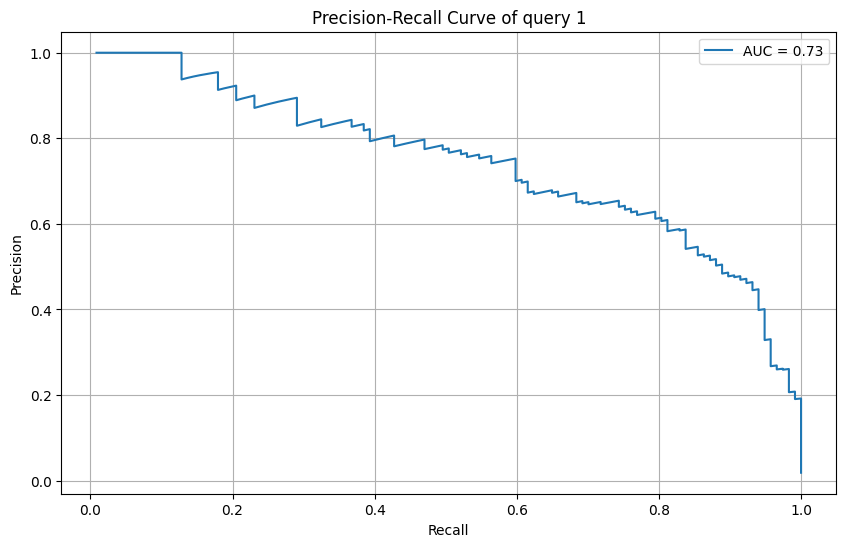

0.7436532434052515


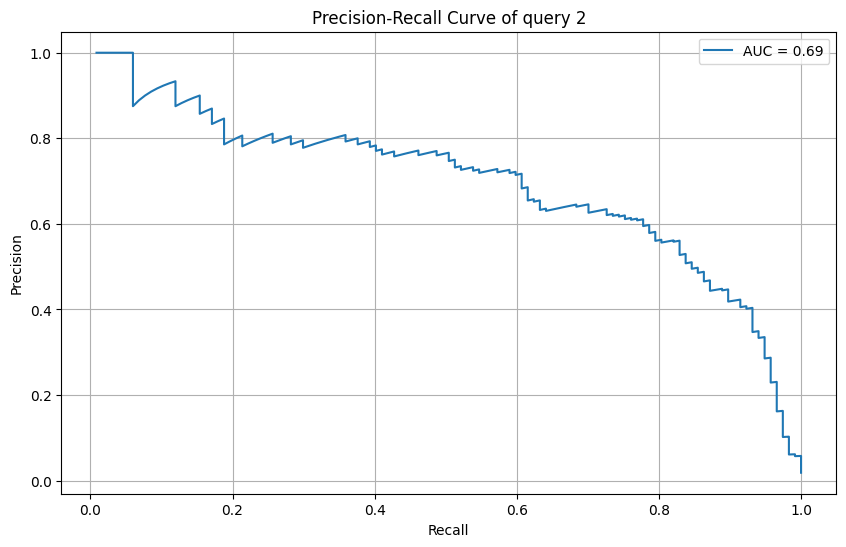

0.6962105848622137


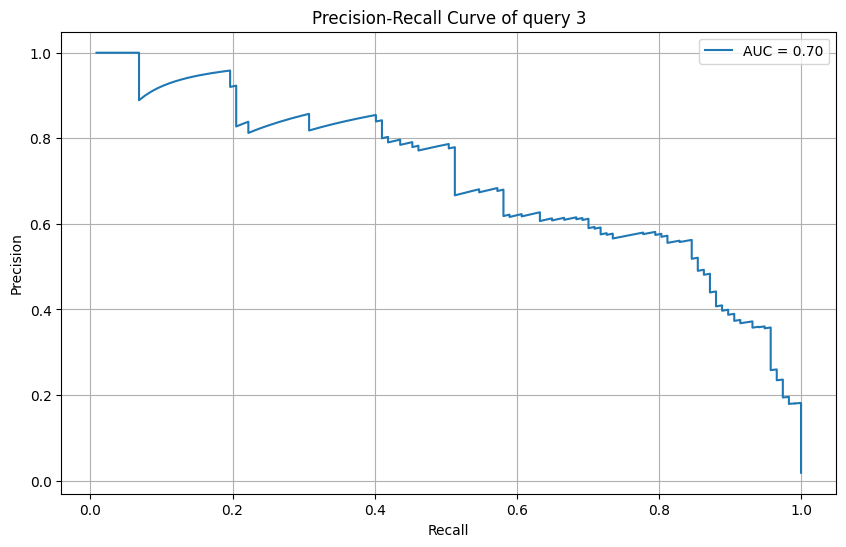

0.7073409662515319


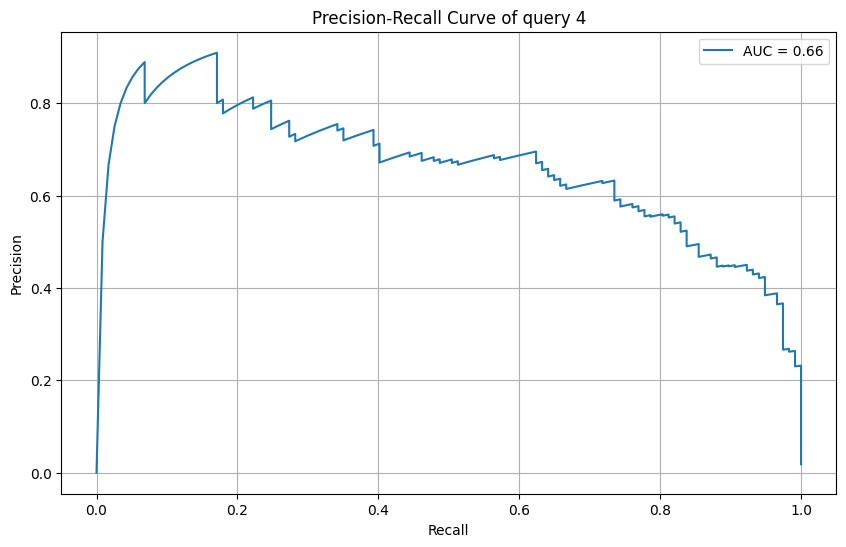

0.6644842414978577


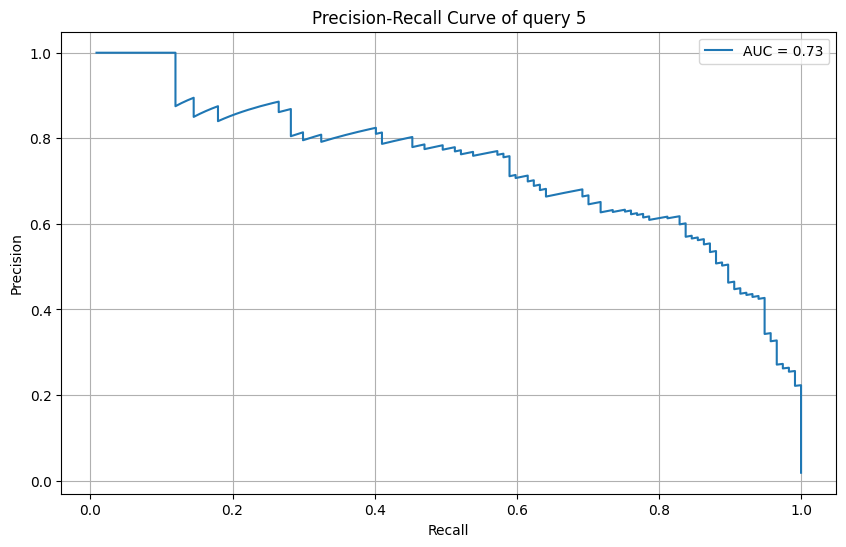

0.7358823865000617


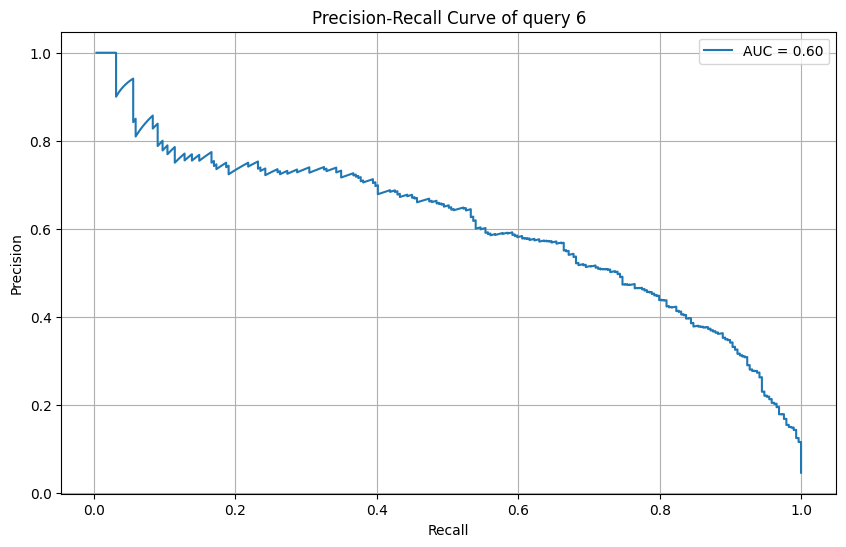

0.6075392823130088


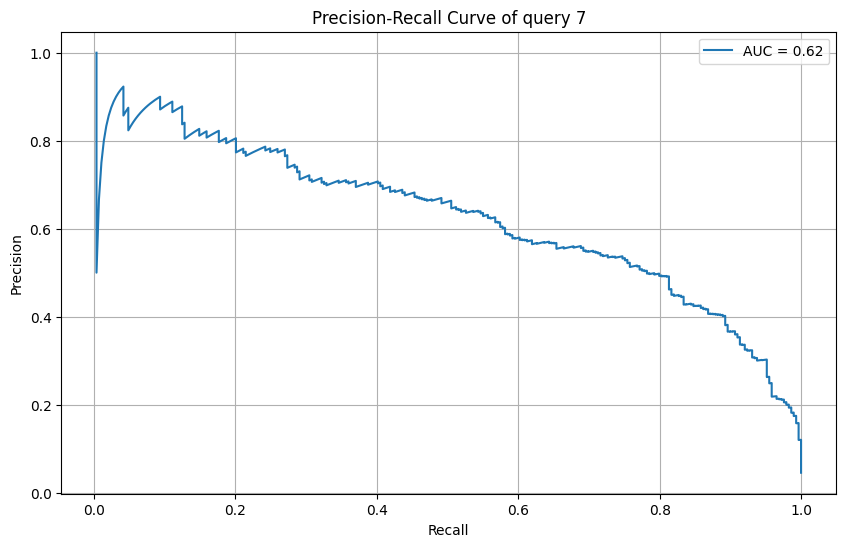

0.6258335052189669


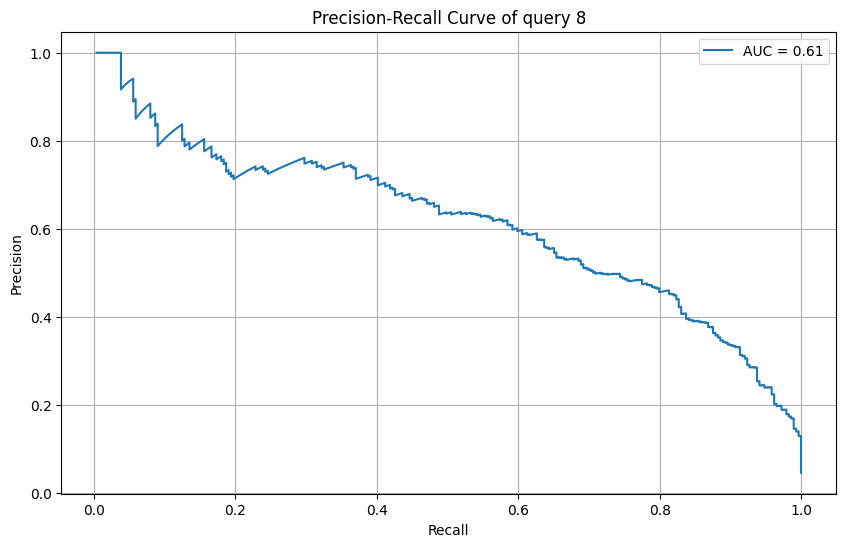

0.616219034541707


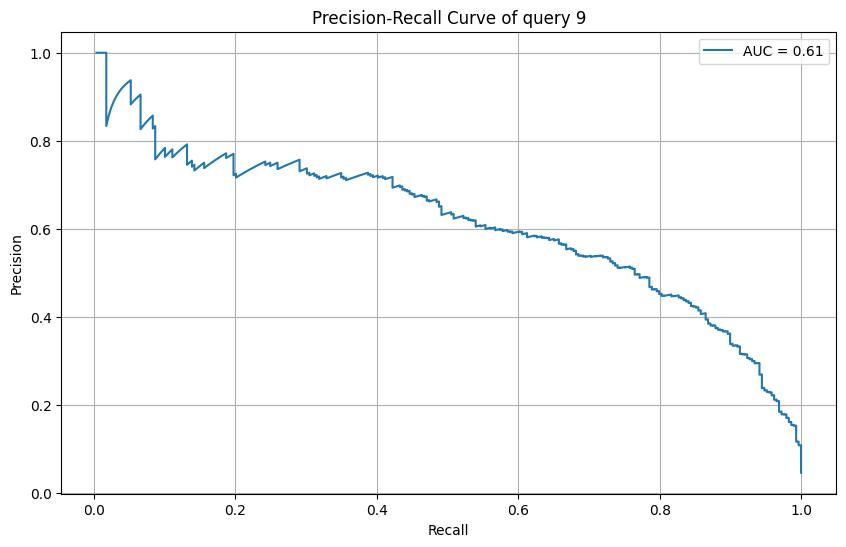

0.6141855540790521


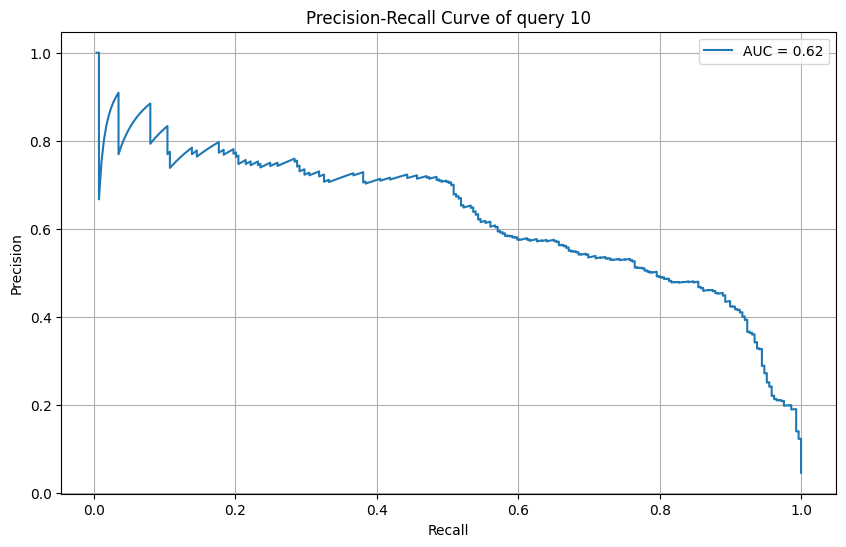

0.6281154531760822


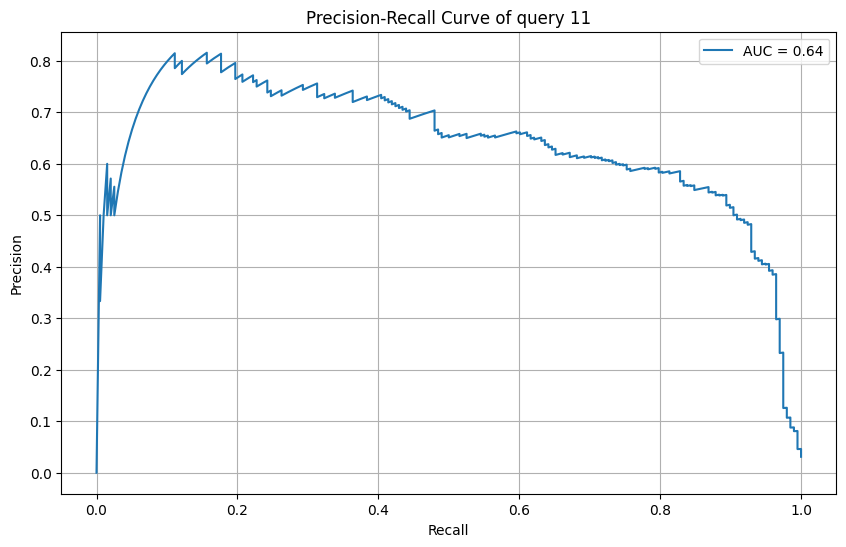

0.6433412083628893


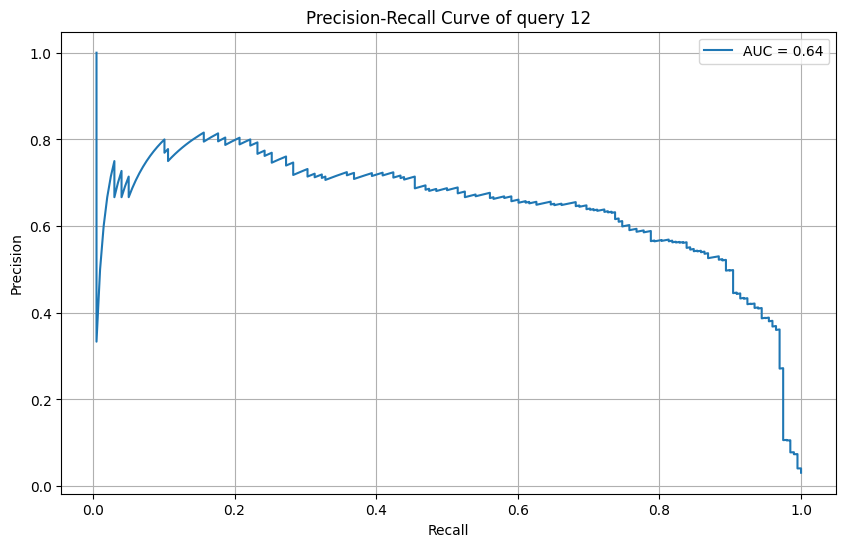

0.6510712698601097


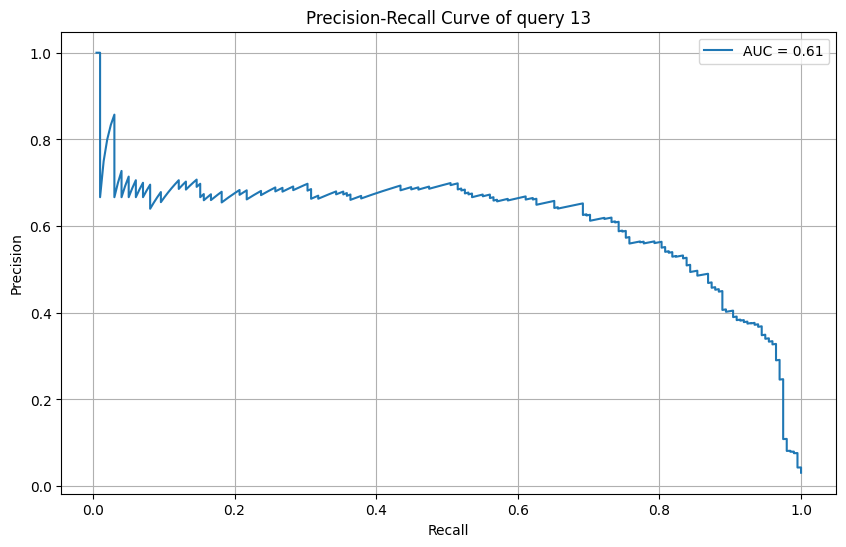

0.6168036942053061


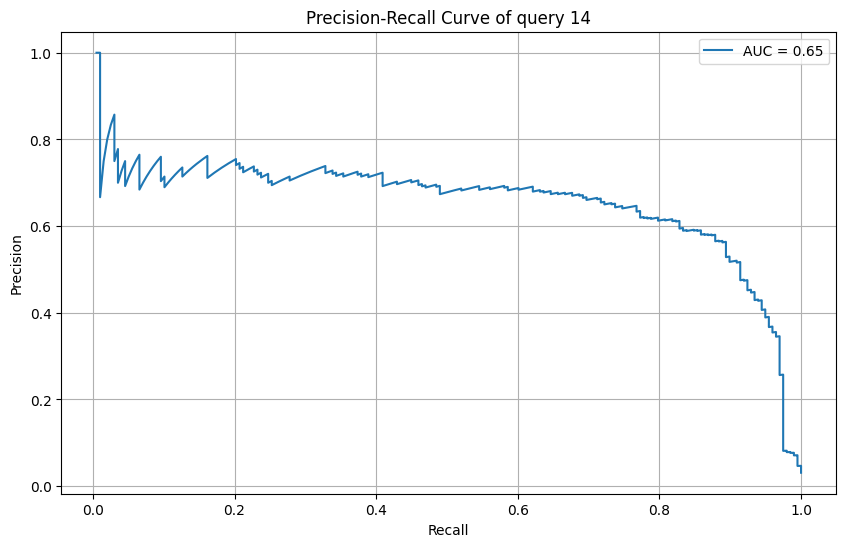

0.658671621626496


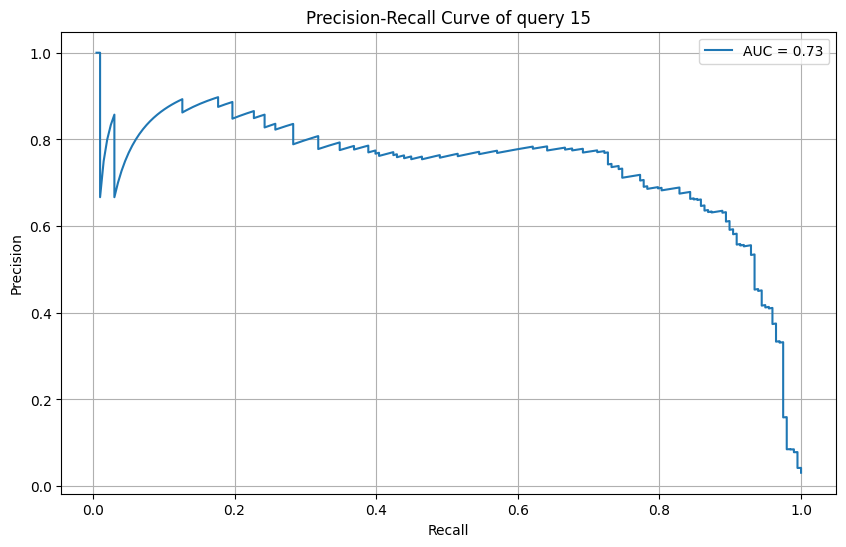

0.7406839698342987


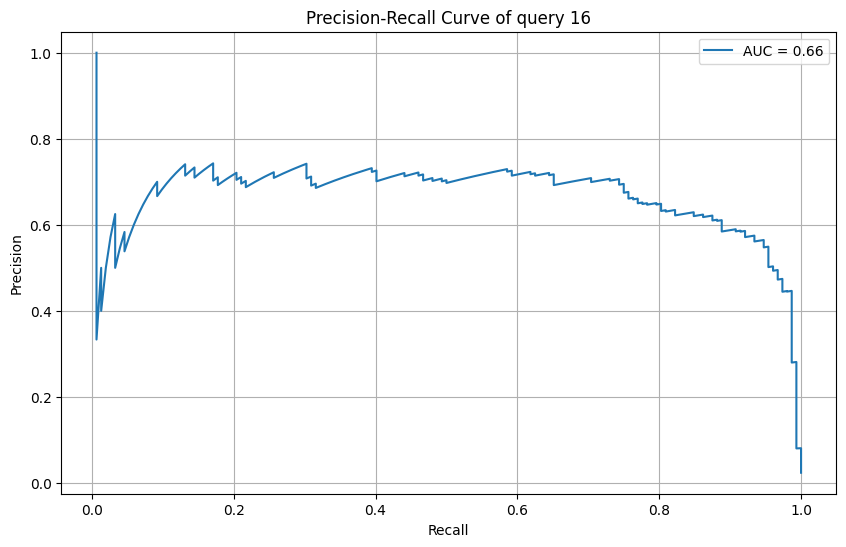

0.6712999537751293


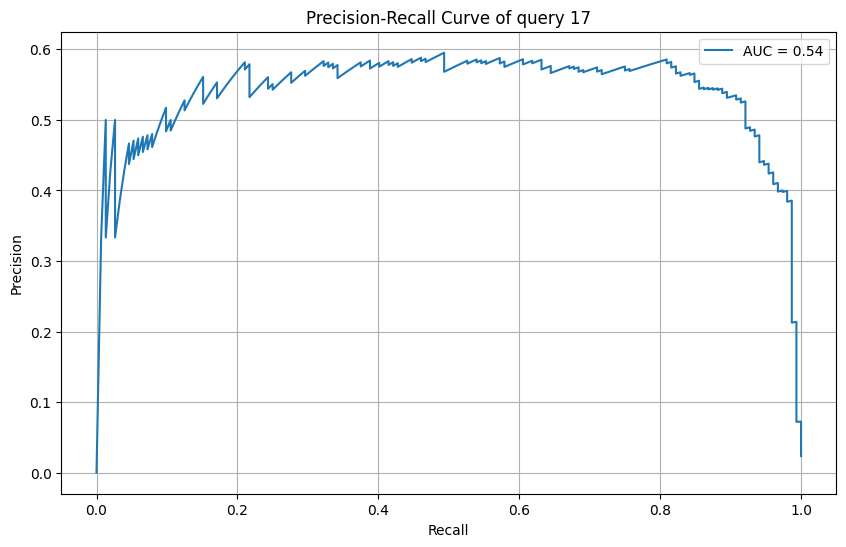

0.5431225291530665


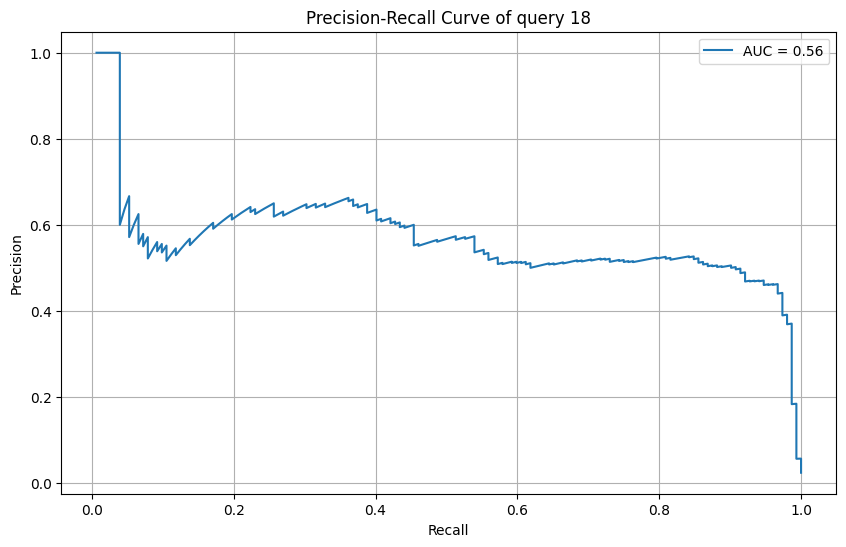

0.5706388171864817


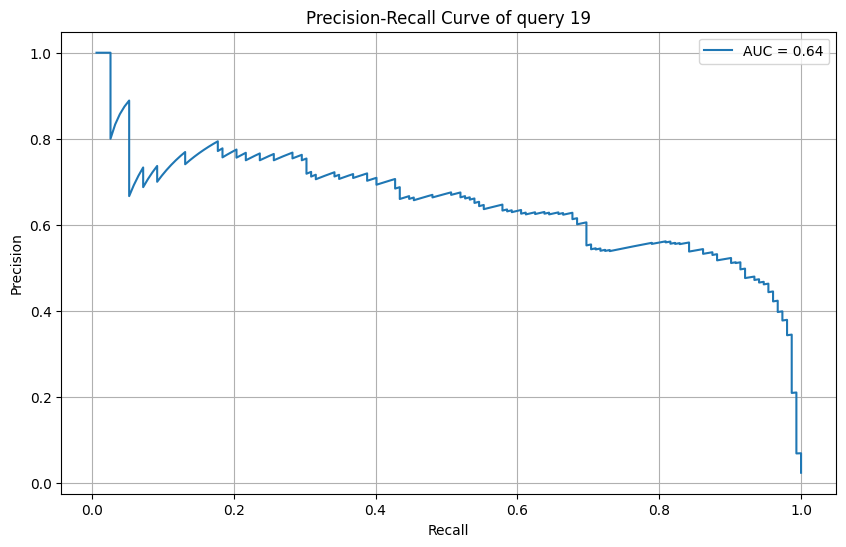

0.6530356386922942


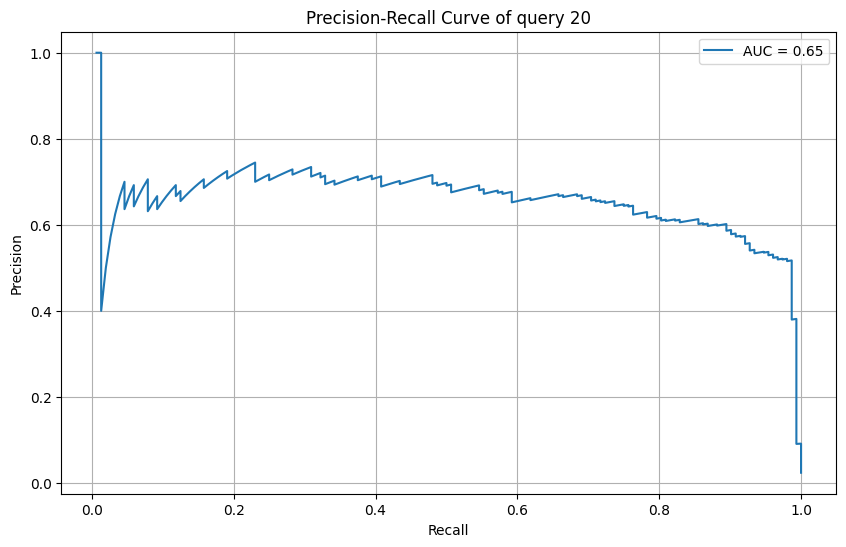

0.6624237287679676


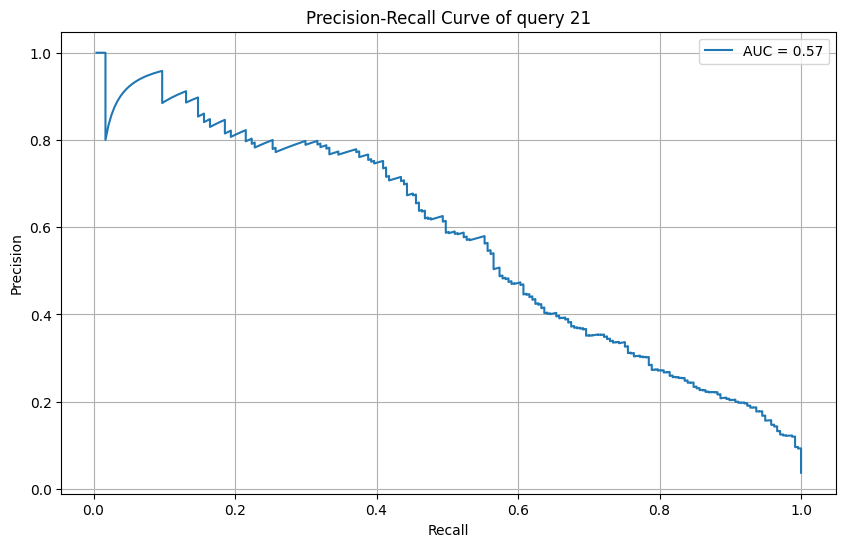

0.5714411586237941


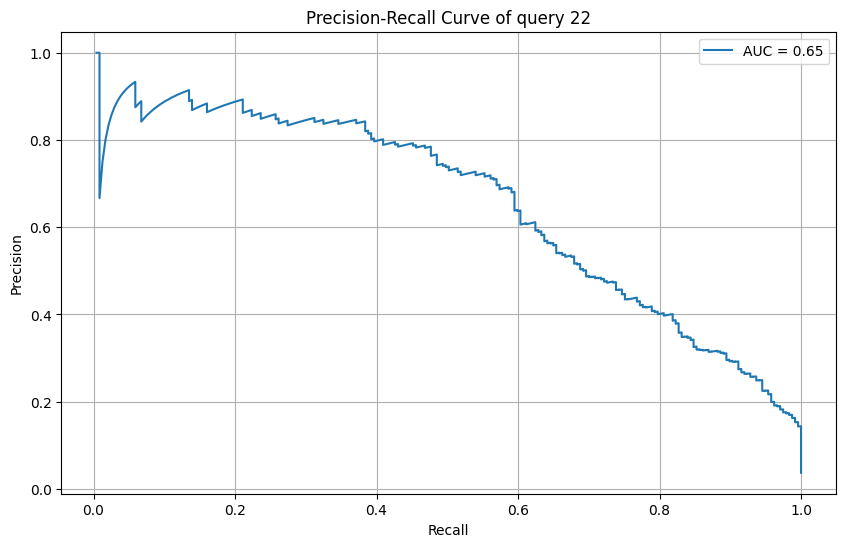

0.6535299223136054


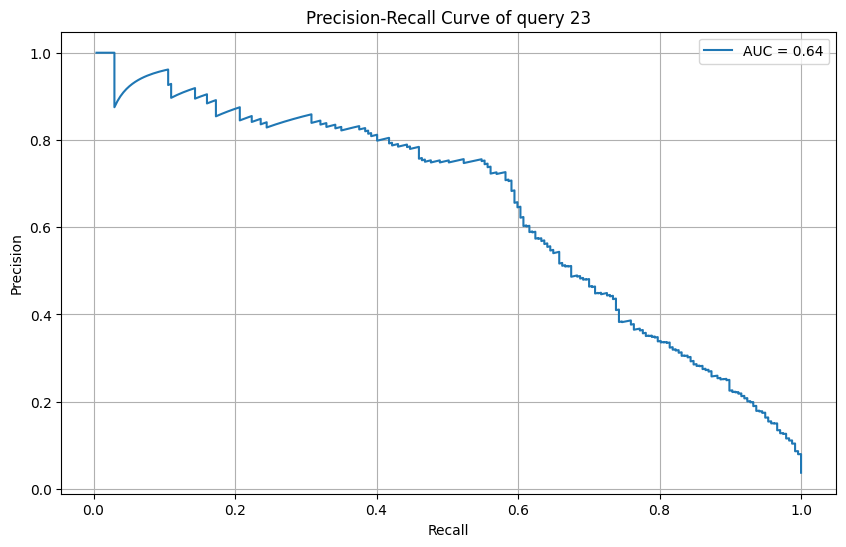

0.6440040094567759


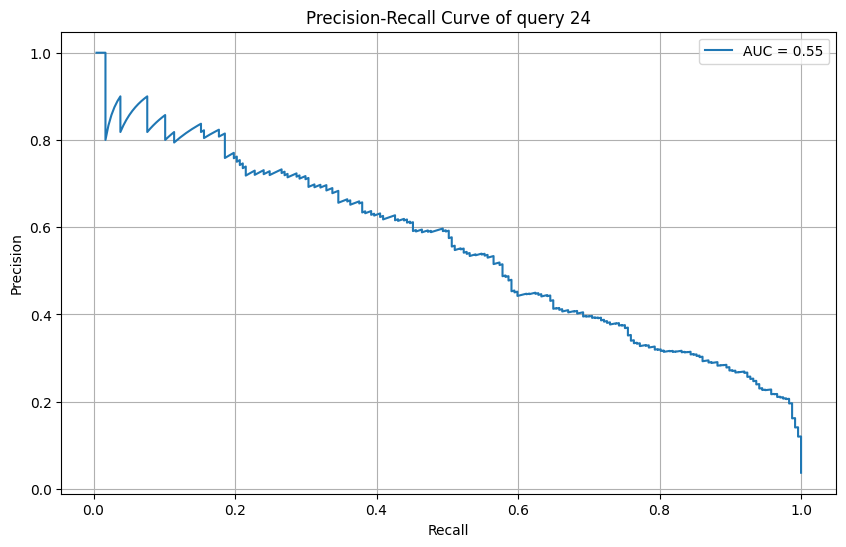

0.5541835047448495


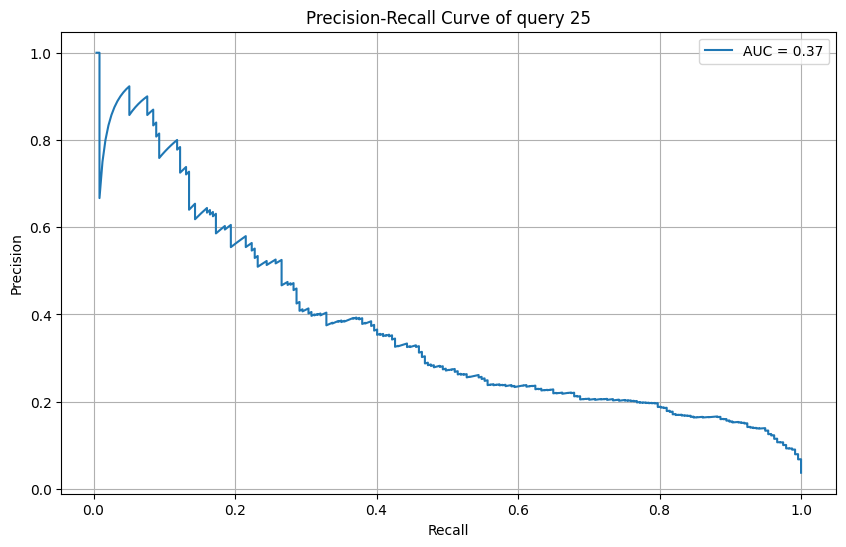

0.37316901607876063


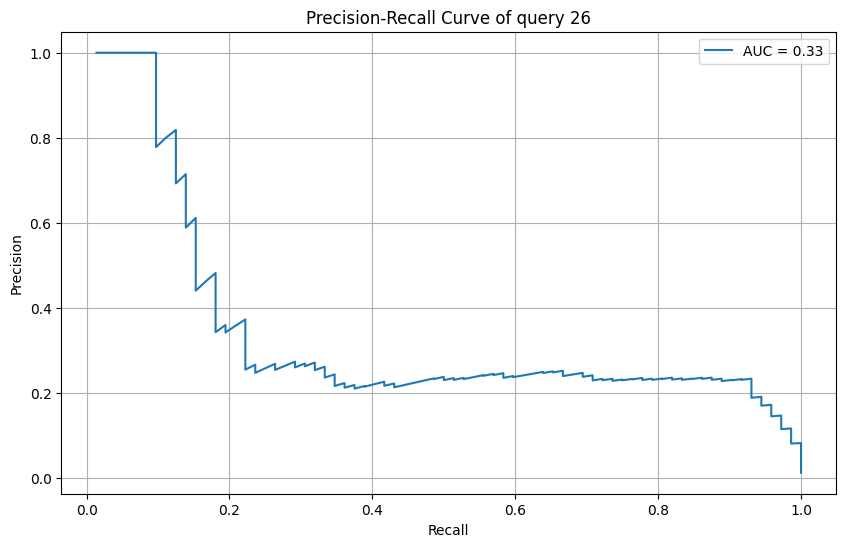

0.3454483998165752


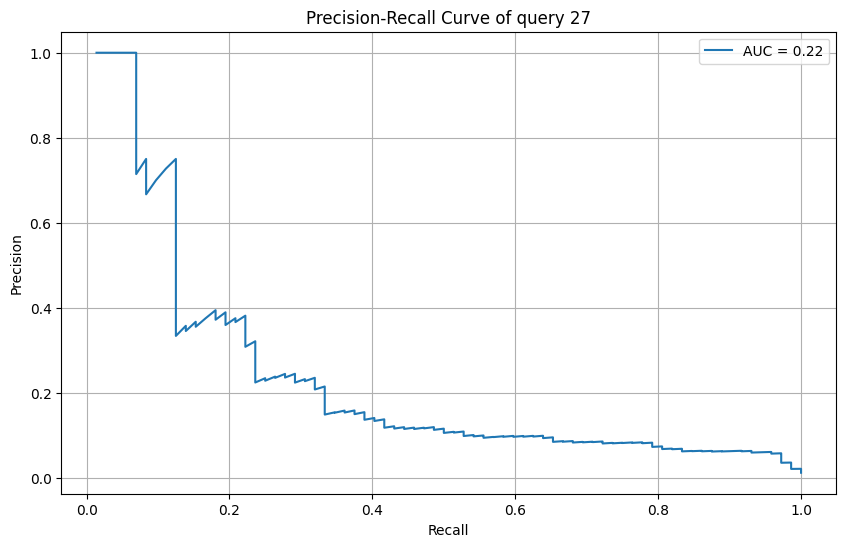

0.23529663617868968


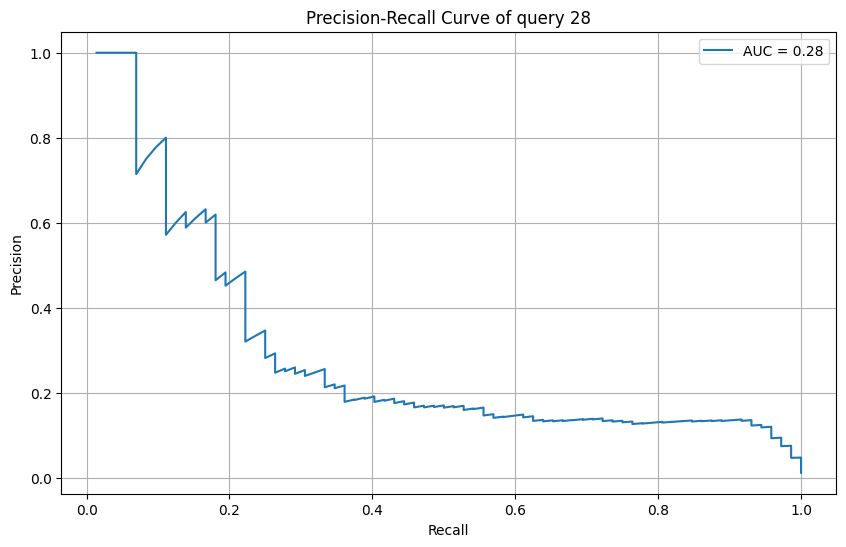

0.2934545502476061


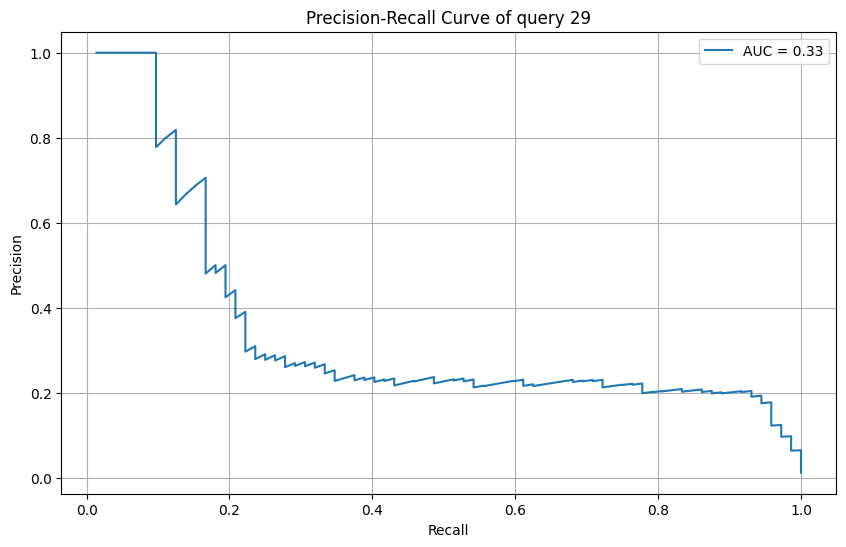

0.3466509241759973


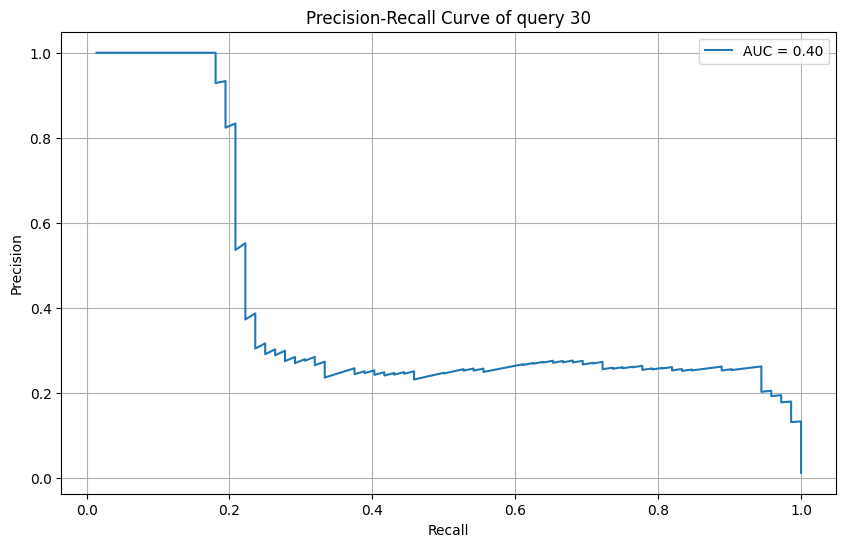

0.41372781939236647


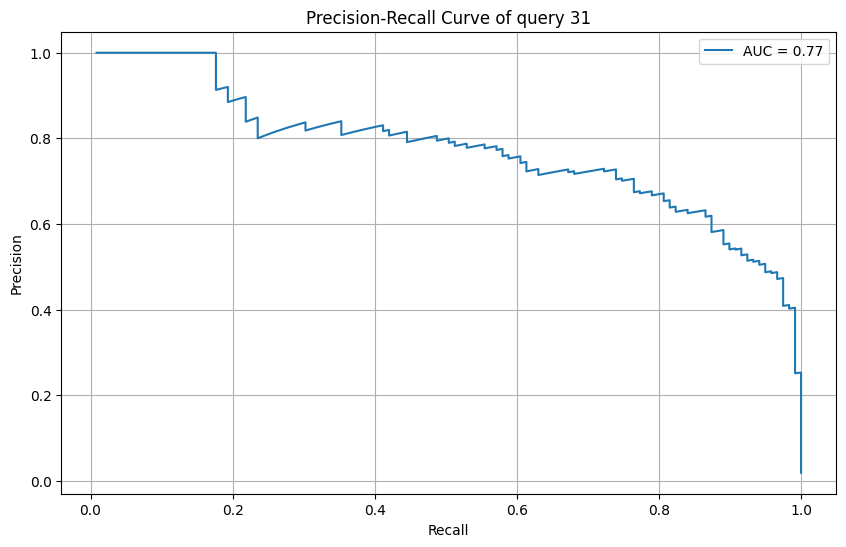

0.7751681646778918


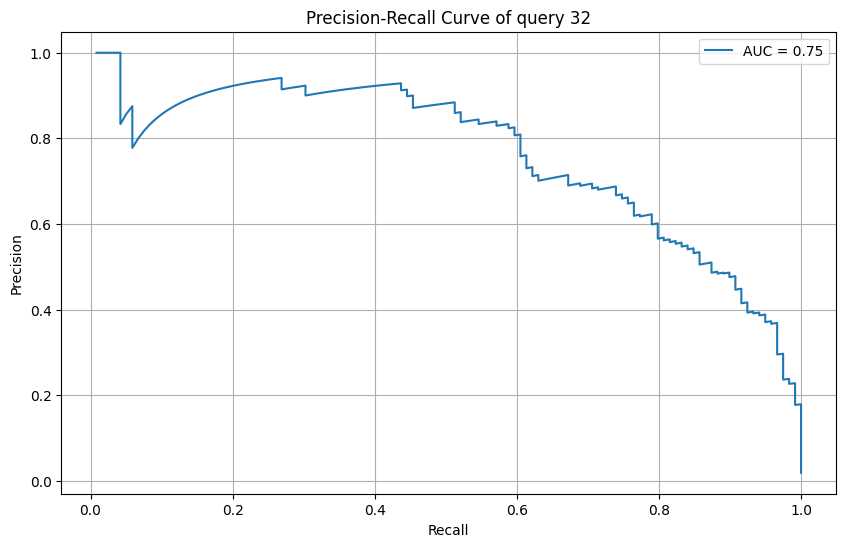

0.7641339030505964


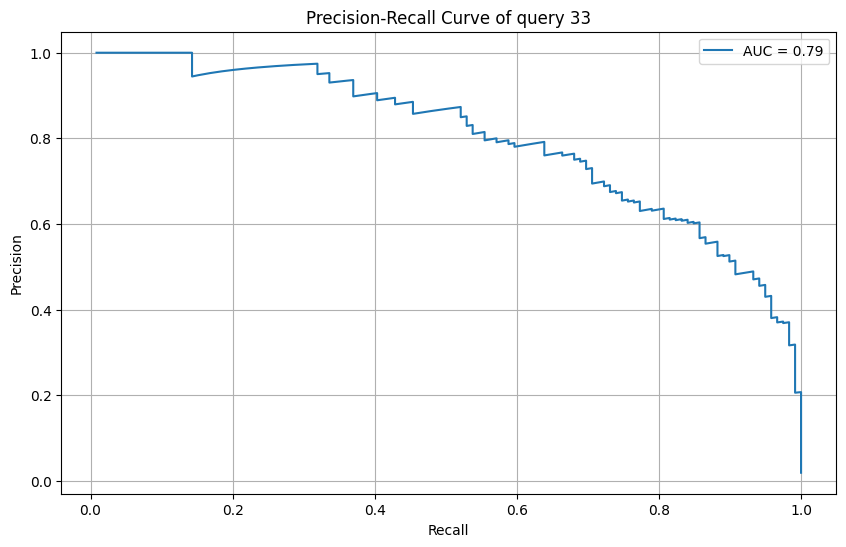

0.8011974423605611


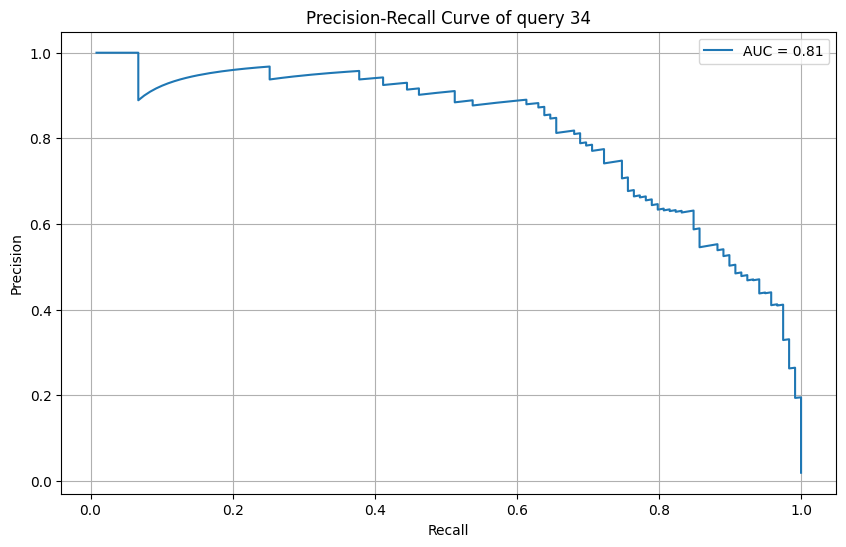

0.818506262108238


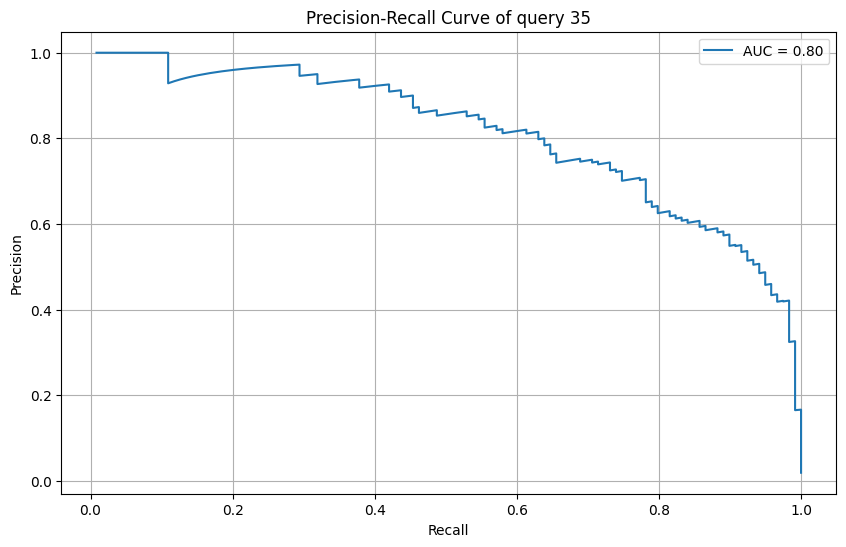

0.8121204094516835


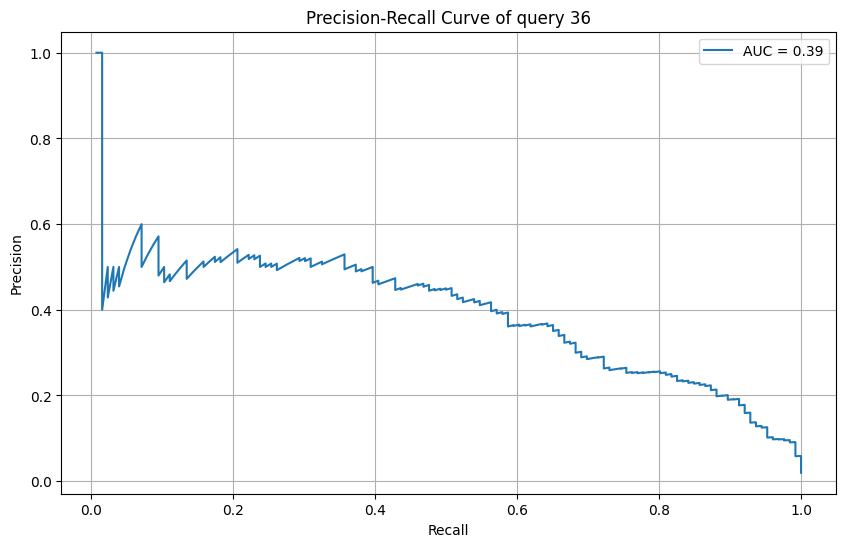

0.39743349380866067


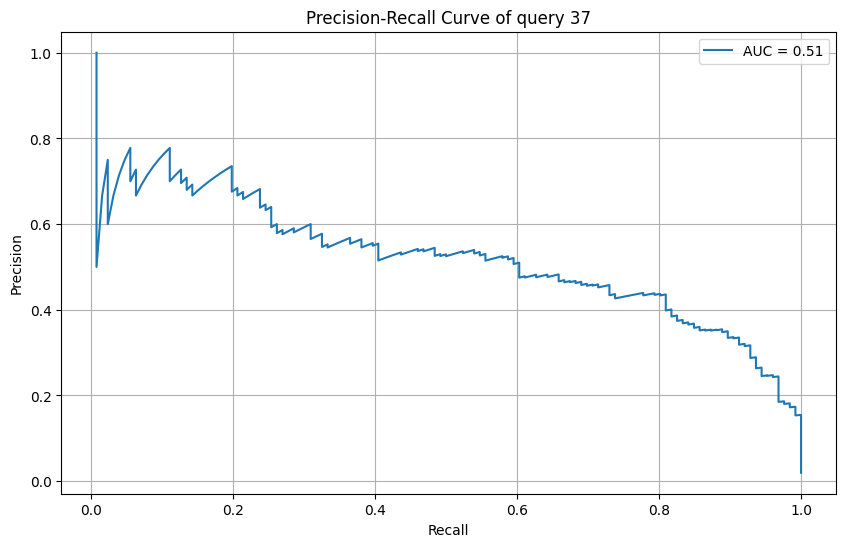

0.526121623839644


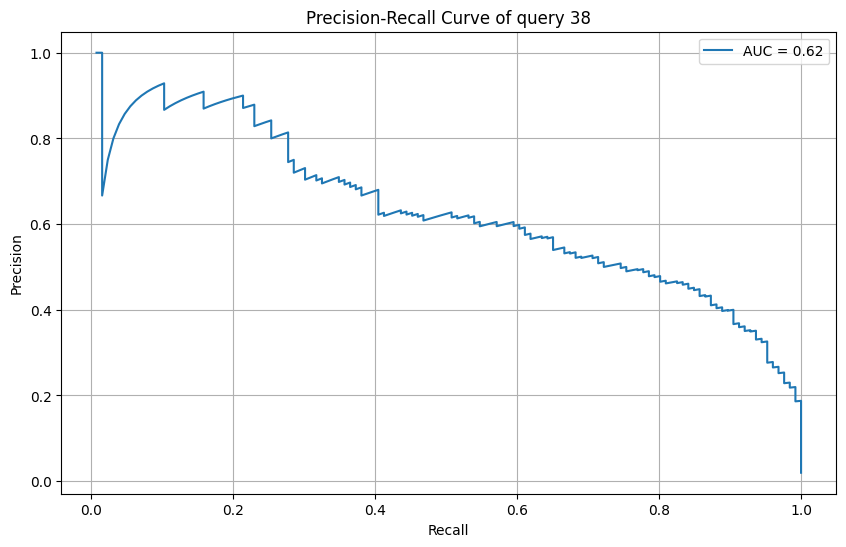

0.6333552310605668


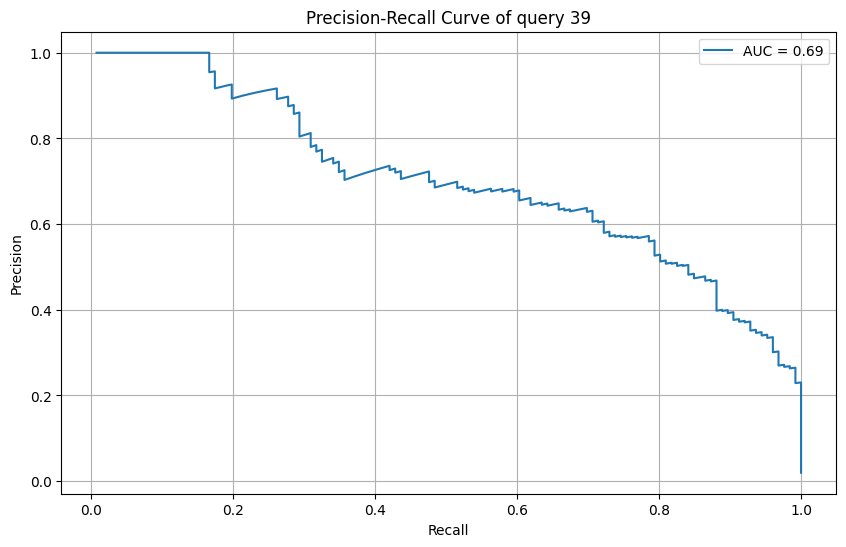

0.7036705391668509


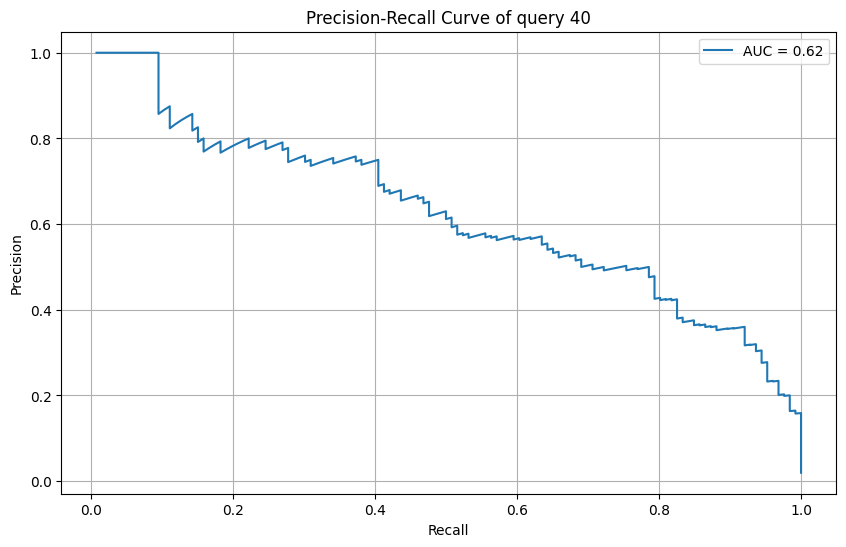

0.6264910911951708


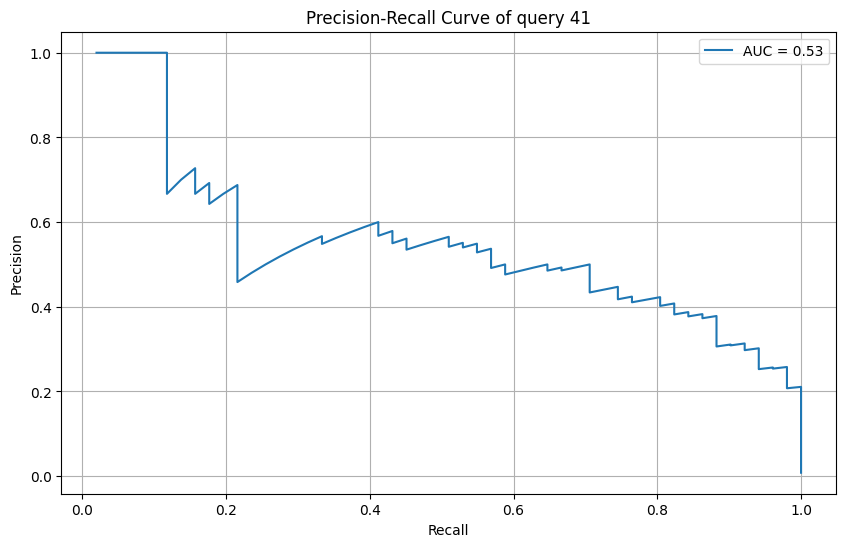

0.553259721969609


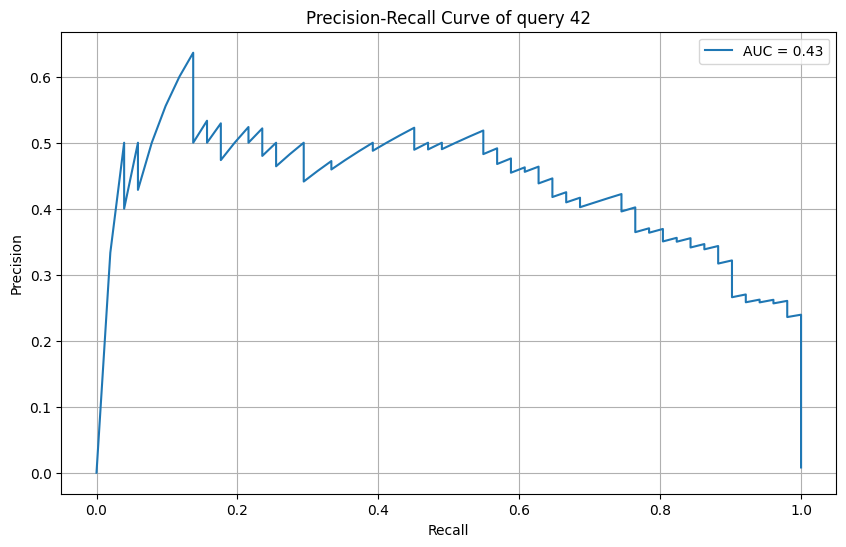

0.44621010903637437


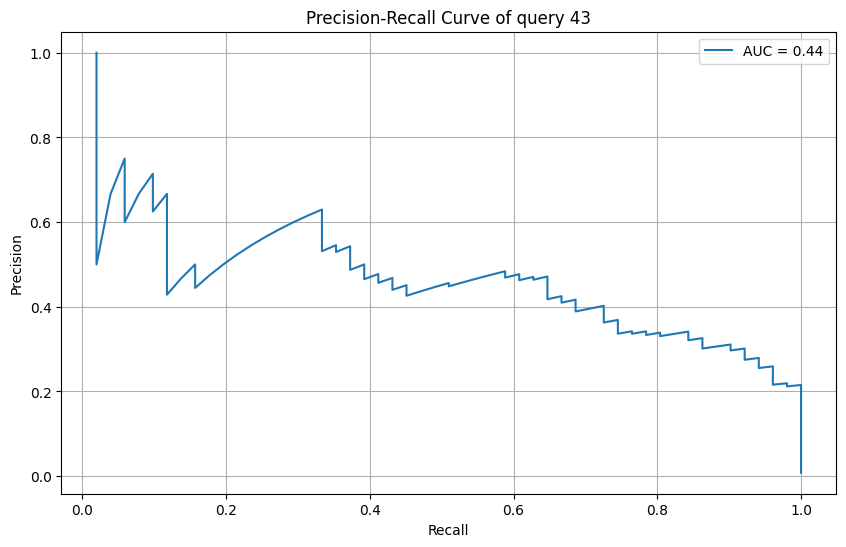

0.4709607136146625


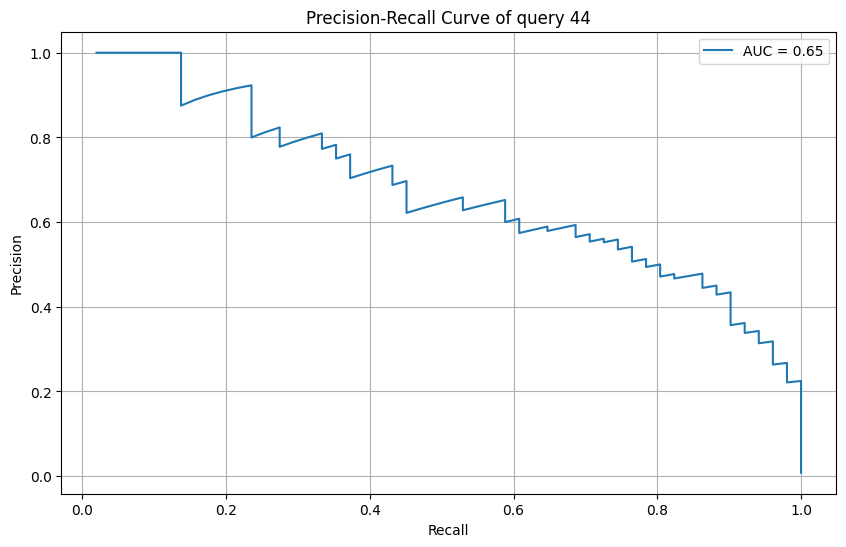

0.6770309506019383


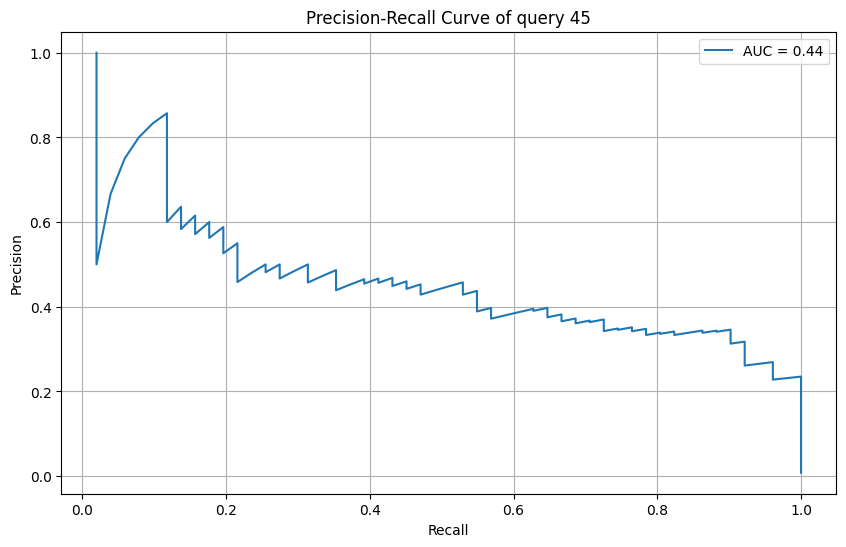

0.4653718917751994


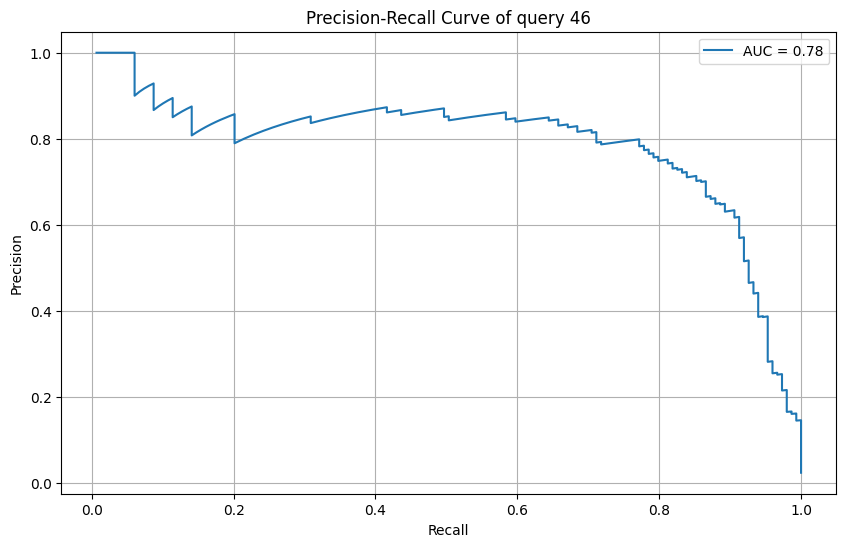

0.790344817231357


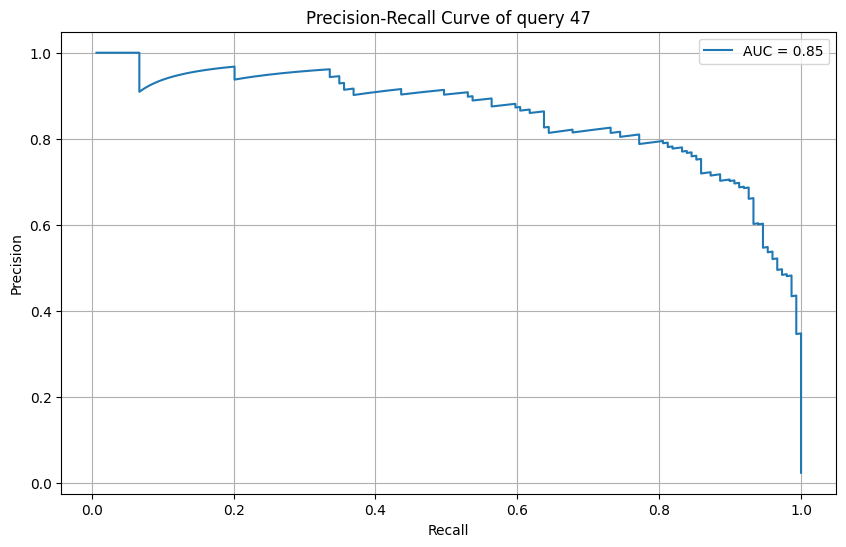

0.8578656786795086


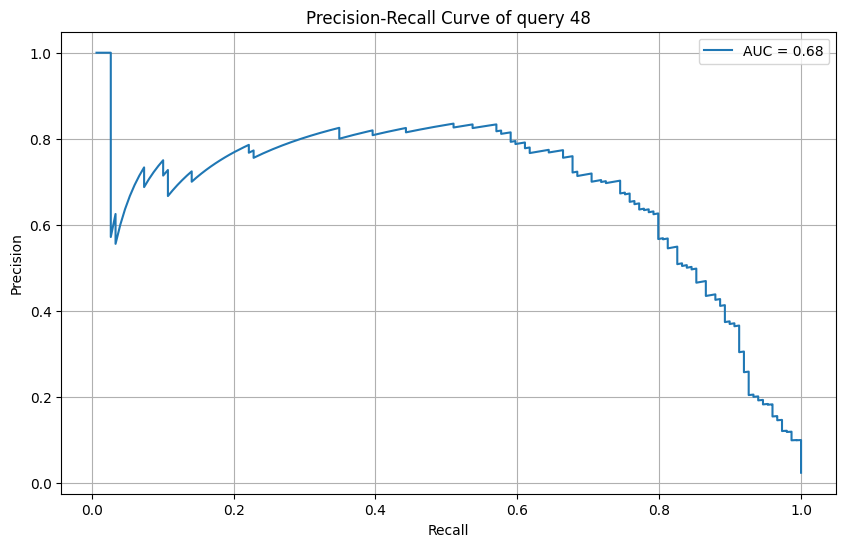

0.6855954483007144


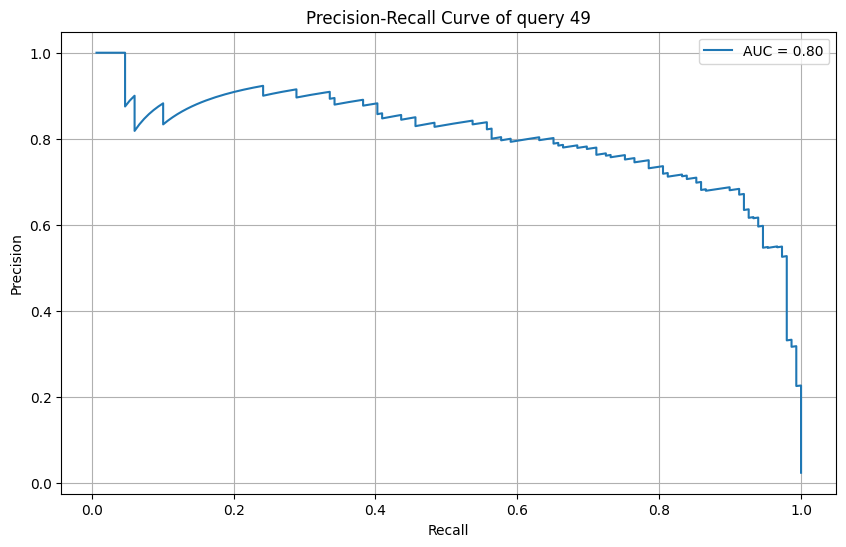

0.8071247685770635


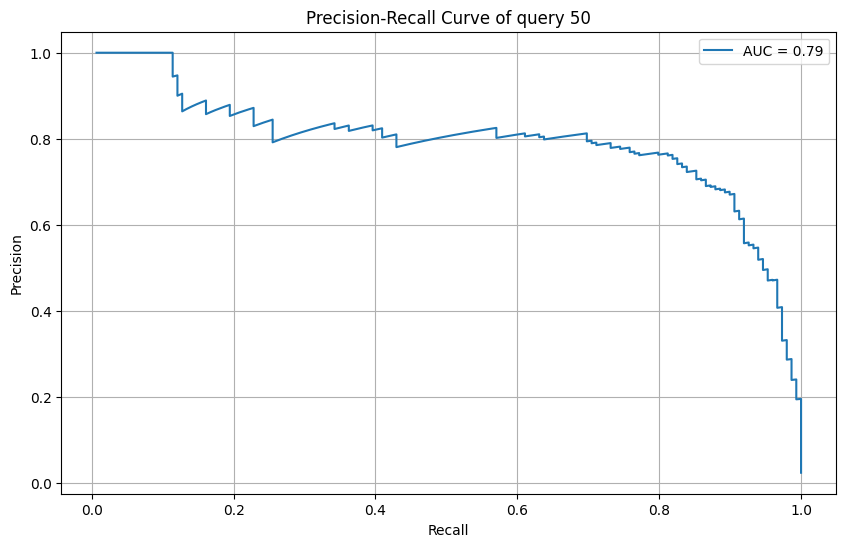

0.7941568377579018


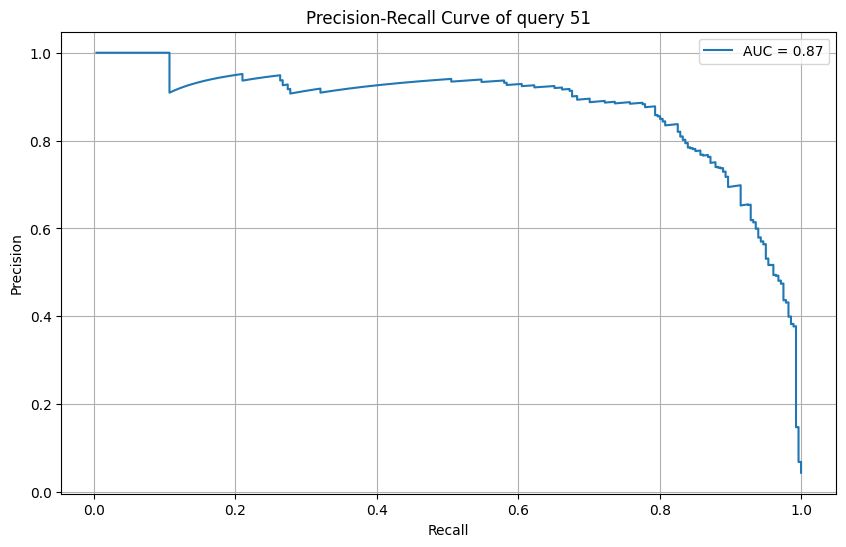

0.8769100839757549


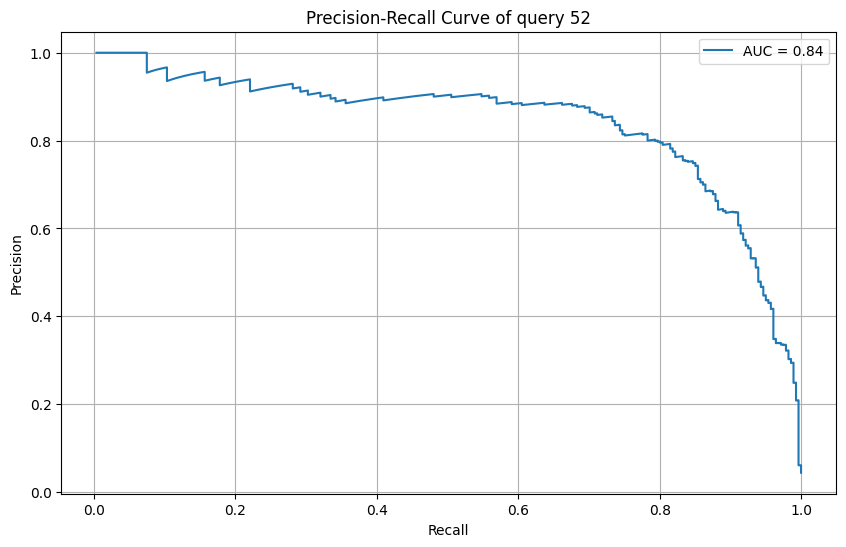

0.8423277304167963


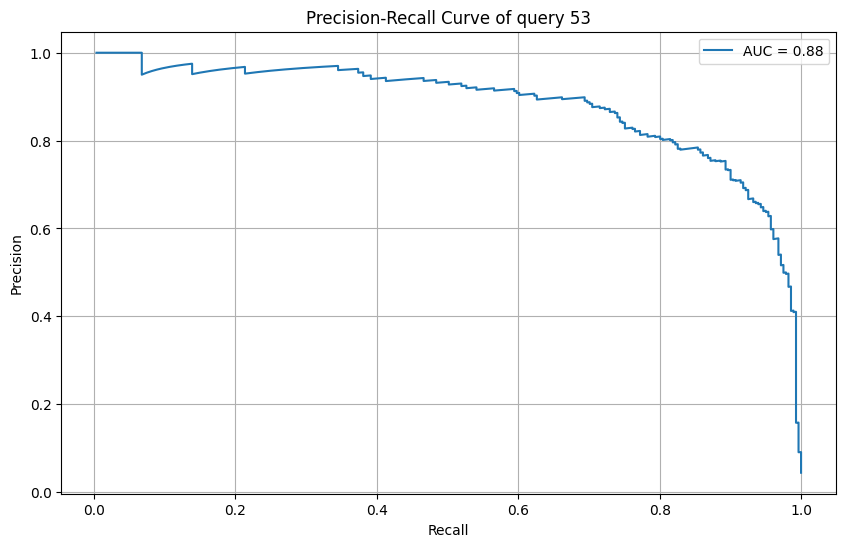

0.8825271723237691


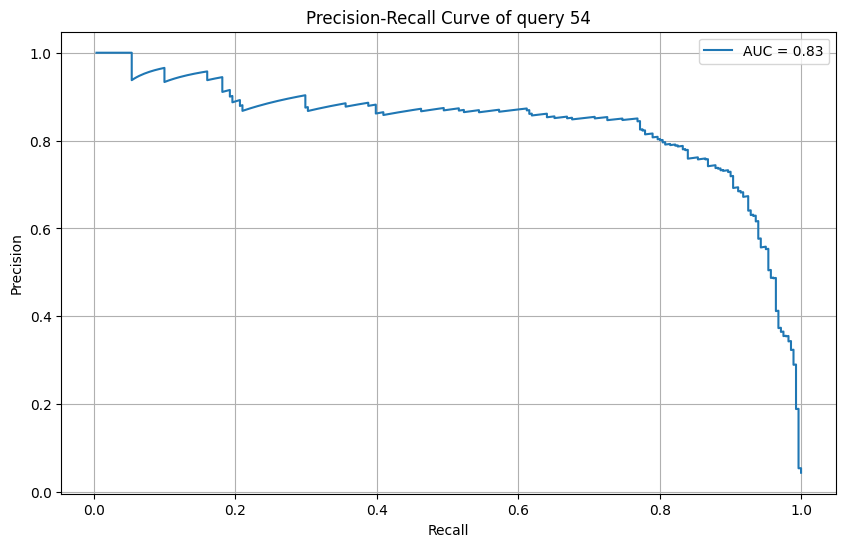

0.8388493590728456


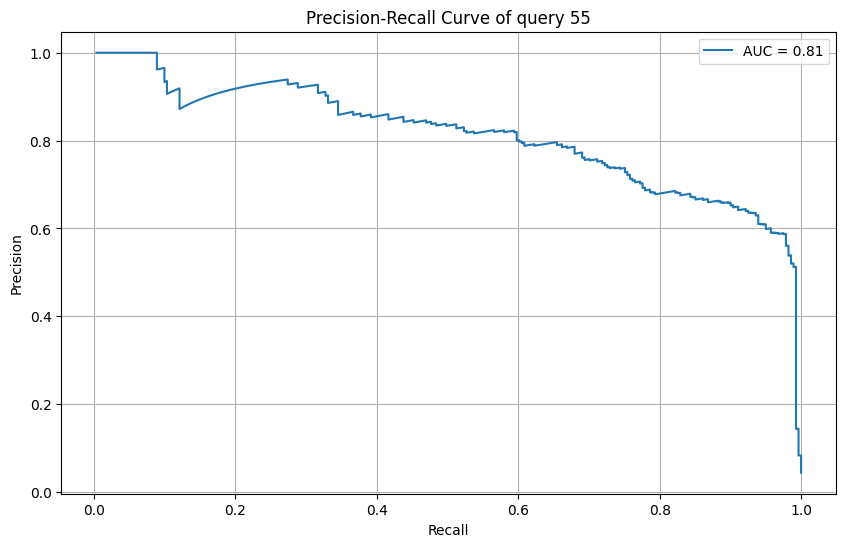

0.813151975762061


In [119]:
queries = []
for i in range(len(rank_list)):
    relevant_items = ground_truths[i]
    retrieved_items = rank_list[i]
    queries.append((relevant_items, retrieved_items))
    plot_precision_recall_curve(queries=[(relevant_items, retrieved_items)], tittle=f'Precision-Recall Curve of query {i+1}')
    print(average_precision(relevant_items=relevant_items, retrieved_items=retrieved_items))

In [120]:
print(map_qr[25])
print(map_qr[26])
print(map_qr[27])
print(map_qr[28])
print(map_qr[29])
print(map_qr[30])
print(map_qr[26])
print(map_qr[41])
print(map_qr[42])
print(map_qr[43])

museedorsay_1
museedorsay_2
museedorsay_3
museedorsay_4
museedorsay_5
notredame_1
museedorsay_2
pompidou_2
pompidou_3
pompidou_4


In [118]:
mean_average_precision(queries=queries)

0.6389336008028039